# LSTM

Model : LSTM

Data : KOSDAQ 2020.01.01 ~ 2024.04.30 / 2020년 1월 2일 기준 시총 300억 이하만 활용

Feature : '시가', '고가', '저가', '종가', '거래량'

Scaler : Standard

## Data Load

In [10]:
import pandas as pd
import numpy as np
from pykrx import stock
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

In [11]:
# 파일 경로
file_path = '/Users/yangdong-yeong/Desktop/Fnguide/data/kosdaq_2020~2024.csv'

# CSV 파일 불러오기
df = pd.read_csv(file_path)

# 'ticker' 열의 값을 문자열로 변환하고, 5자리인 경우 앞에 '0'을 추가
df['ticker'] = df['ticker'].astype(str).str.zfill(6)

# 변경된 데이터 확인
print(df.head(5))

/var/folders/h0/rz02629x2b535_x0qf1h70zm0000gn/T/ipykernel_27708/2171151300.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


           날짜    시가    고가    저가    종가     거래량       등락률  ticker
0  2020-01-02  2820  2845  2780  2795  131742 -0.886525  060310
1  2020-01-03  2795  2825  2775  2810  100374  0.536673  060310
2  2020-01-06  2800  2805  2650  2685  201779 -4.448399  060310
3  2020-01-07  2685  2745  2685  2745   62241  2.234637  060310
4  2020-01-08  2720  2745  2580  2585  203909 -5.828780  060310


In [12]:
df.shape

(1597711, 8)

In [13]:
# 시가총액 데이터 가져오기
market_cap_df = stock.get_market_cap("20200102")  # 2020년 1월 2일 데이터
market_cap_df = market_cap_df[(market_cap_df['시가총액'] > 0) & (market_cap_df['시가총액'] <= 30000000000)]

# 원본 데이터셋 (예를 들어 'df')에서 시가총액 300억 이하인 종목만 추출
filtered_tickers = market_cap_df.index
df = df[df['ticker'].isin(filtered_tickers)]

## Data Processing

In [14]:
#날짜 포맷 확인 및 변환
df['날짜'] = pd.to_datetime(df['날짜'])

# ticker 별로 데이터 분할
tickers = tickers = df['ticker'].unique()
ticker_df = {ticker: df[df['ticker'] == ticker] for ticker in tickers}

In [15]:
# 스케일링
scalers = {ticker: StandardScaler() for ticker in tickers}

for ticker in tickers:
    df_copy = ticker_df[ticker].copy()
    df_copy[['시가', '고가', '저가', '종가', '거래량']] = df_copy[['시가', '고가', '저가', '종가', '거래량']].astype(float)
    
    # 데이터 스케일링
    scaled_data = scalers[ticker].fit_transform(df_copy[['시가', '고가', '저가', '종가', '거래량']])
    
    # 스케일된 데이터를 DataFrame으로 만들고, 원본과 같은 데이터 형식(int)으로 캐스팅합니다.
    scaled_df = pd.DataFrame(scaled_data, columns=['시가', '고가', '저가', '종가', '거래량'], index=df_copy.index)
    for col in ['시가', '고가', '저가', '종가', '거래량']:
        # 원본 데이터의 데이터 타입에 맞춰 캐스팅합니다.
        scaled_df[col] = scaled_df[col].astype(ticker_df[ticker][col].dtype)

    # 스케일된 데이터를 원본 DataFrame에 적용
    ticker_df[ticker].loc[:, ['시가', '고가', '저가', '종가', '거래량']] = scaled_df

# 메모리 문제로 파일 중간 저장
all_data = pd.concat([ticker_df[ticker] for ticker in tickers], axis=0, ignore_index=True)
all_data.to_csv('/Users/yangdong-yeong/Desktop/Fnguide/data/kosdaq_300억_scaled.csv', index=False)

In [16]:
# CSV 파일 불러오기
file_path = '/Users/yangdong-yeong/Desktop/Fnguide/data/kosdaq_300억_scaled.csv'
ticker_df = pd.read_csv(file_path)

# '날짜' 열을 datetime 객체로 변환
ticker_df['날짜'] = pd.to_datetime(ticker_df['날짜'])

# ticker 별로 데이터 분할
tickers = ticker_df['ticker'].unique()
ticker_data = {ticker: ticker_df[ticker_df['ticker'] == ticker] for ticker in tickers}

In [17]:
# 시퀀스 데이터와 레이블 생성 함수
def create_sequences_and_labels(df, sequence_length, threshold=20, look_forward=30):
    sequences = []
    labels = []
    if len(df) >= sequence_length + look_forward:

        for i in range(len(df) - sequence_length - look_forward + 1):
            sequence_start = i
            sequence_end = i + sequence_length
            future_start = sequence_end
            future_end = future_start + look_forward

            sequences.append(df[['시가', '고가', '저가', '종가', '거래량']].iloc[sequence_start:sequence_end].values)
            future_data = df.iloc[future_start:future_end]
            # 등락률을 사용하여 레이블 결정
            labels.append(any(future_data['등락률'] >= threshold))

        return np.array(sequences), np.array(labels).astype(int)
    else:
        return np.array([]), np.array([])  # 데이터 포인트가 부족할 경우 빈 배열 반환
    
# 시퀀스 길이 설정
sequence_length = 180  # 과거 180일의 데이터로 시퀀스 생성
num_features = 5

# 각 ticker 별로 시퀀스와 레이블 생성
ticker_sequences_and_labels = {ticker: create_sequences_and_labels(ticker_data[ticker], sequence_length) for ticker in tickers}

# 모든 ticker의 시퀀스와 레이블을 하나의 리스트에 모으기
all_sequences = []
all_labels = []

for ticker, (sequences, labels) in ticker_sequences_and_labels.items():
    if sequences.size > 0:
        all_sequences.append(sequences)
        all_labels.append(labels)

# 배열로 변환
if all_sequences:
    all_sequences = np.concatenate(all_sequences)
    all_labels = np.concatenate(all_labels)
else:
    all_sequences, all_labels = np.array([]), np.array([])

print(f"Combined Sequences Shape: {all_sequences.shape if all_sequences.size > 0 else 'No sequences available'}")
print(f"Combined Labels Shape: {all_labels.shape if all_labels.size > 0 else 'No labels available'}")


Combined Sequences Shape: (95460, 180, 5)
Combined Labels Shape: (95460,)


In [18]:
# LSTM 모델
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, num_features)),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [19]:
# F1 Score 콜백 정의
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.precision_scores = []
        self.recall_scores = []
        self.f1_scores = []
        self.train_losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs=None):
        val_predict = (self.model.predict(self.X_val) > 0.5).astype(int)
        val_targ = self.y_val
        precision = precision_score(val_targ, val_predict, zero_division=0)
        recall = recall_score(val_targ, val_predict, zero_division=0)
        f1 = f1_score(val_targ, val_predict, zero_division=0)

        # Store the precision, recall, and f1 scores
        self.precision_scores.append(precision)
        self.recall_scores.append(recall)
        self.f1_scores.append(f1)

        # Store the train and validation loss
        self.train_losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

    def plot_metrics(self):
        epochs = range(1, len(self.f1_scores) + 1)
        
        # Plot F1, Precision, and Recall
        plt.figure(figsize=(14, 6))
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.f1_scores, 'go-', label='F1 Score')
        plt.plot(epochs, self.precision_scores, 'ro-', label='Precision')
        plt.plot(epochs, self.recall_scores, 'bo-', label='Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.title('Model Performance Metrics Over Epochs')
        plt.legend()
        plt.grid(True)
        
        # Plot Loss and Validation Loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_losses, 'r-', label='Training Loss')
        plt.plot(epochs, self.val_losses, 'b-', label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Epochs')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

In [20]:
# 데이터 분할
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    all_sequences, all_labels, np.arange(all_sequences.shape[0]), test_size=0.2, random_state=42)


# 체크포인트를 저장할 경로 설정
checkpoint_path = '/Users/yangdong-yeong/Desktop/Fnguide/Check_Point/model_300_{epoch:02d}-{val_loss:.2f}.h5'

# 콜백 인스턴스 생성
f1_callback = F1ScoreCallback(X_test, y_test)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


# 클래스 가중치 계산
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

Epoch 1/10
597/597 [==============================] - 9s 14ms/step
1194/1194 - 59s - loss: 0.6647 - accuracy: 0.6571 - precision_1: 0.1712 - recall_1: 0.5485 - val_loss: 0.6611 - val_accuracy: 0.6517 - val_precision_1: 0.1688 - val_recall_1: 0.5704 - 59s/epoch - 49ms/step
Epoch 2/10
597/597 [==============================] - 8s 14ms/step
1194/1194 - 58s - loss: 0.6757 - accuracy: 0.6335 - precision_1: 0.1501 - recall_1: 0.4980 - val_loss: 0.6415 - val_accuracy: 0.7538 - val_precision_1: 0.1872 - val_recall_1: 0.3858 - 58s/epoch - 49ms/step
Epoch 3/10
597/597 [==============================] - 8s 14ms/step
1194/1194 - 58s - loss: 0.6691 - accuracy: 0.6577 - precision_1: 0.1659 - recall_1: 0.5218 - val_loss: 0.6074 - val_accuracy: 0.7120 - val_precision_1: 0.1835 - val_recall_1: 0.4866 - 58s/epoch - 48ms/step
Epoch 4/10
597/597 [==============================] - 8s 14ms/step
1194/1194 - 58s - loss: 0.6604 - accuracy: 0.6142 - precision_1: 0.1664 - recall_1: 0.6224 - val_loss: 0.6615 - va

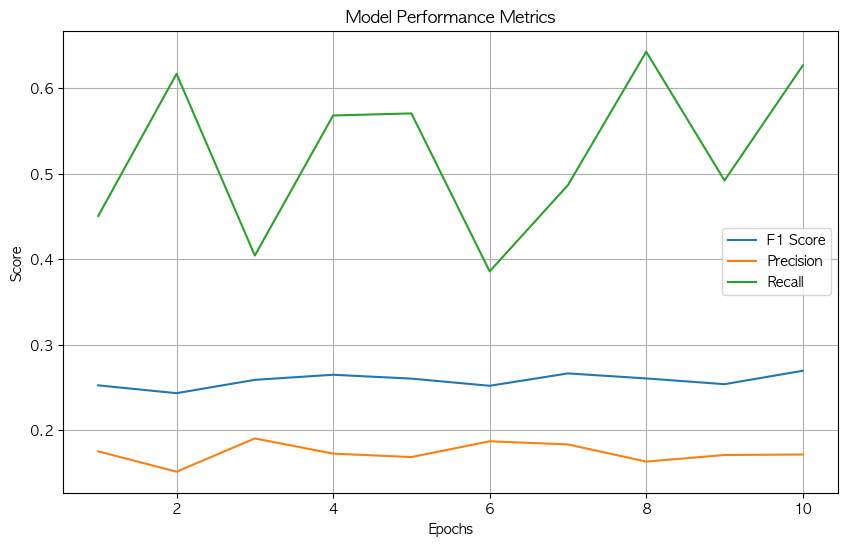

In [24]:
# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[f1_callback, early_stopping, model_checkpoint_callback],
    class_weight=class_weight_dict,  # 클래스 가중치 사용
    verbose=2
)

# 학습 완료 후 지표 플로팅
f1_callback.plot_metrics()

In [25]:
# 모델 예측
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)

# 양성으로 예측된 샘플의 인덱스 추출
positive_indices = np.where(predicted_labels == 1)[0]
positive_actual_indices = indices_test[positive_indices]
positive_predicted_labels = predicted_labels[positive_indices]

# df의 인덱스를 재조정하여 일관성 유지
df.reset_index(inplace=True, drop=True)

# 원본 데이터에서 해당 인덱스의 'ticker'와 실제 레이블 추출
# df의 인덱스가 0부터 시작한다고 가정하여 인덱스를 매핑합니다.
try:
    positive_tickers = df.loc[positive_actual_indices, 'ticker']
    actual_labels = y_test[positive_indices]  # y_test에서 양성으로 예측된 인덱스의 실제 레이블 추출
except KeyError as e:
    print(f"An error occurred: {e}")
    print(f"Check if df indices and positive_actual_indices are correctly aligned.")

# 결과 출력
for idx, ticker, pred_label, act_label in zip(positive_actual_indices, positive_tickers, positive_predicted_labels, actual_labels):
    print(f"Original Index: {idx}, Ticker: {ticker}, Predicted: {pred_label}, Actual: {act_label}")

597/597 [==============================] - 8s 14ms/step
Original Index: 68641, Ticker: 323230, Predicted: [1], Actual: 0
Original Index: 21499, Ticker: 023790, Predicted: [1], Actual: 0
Original Index: 79094, Ticker: 336060, Predicted: [1], Actual: 0
Original Index: 29723, Ticker: 200350, Predicted: [1], Actual: 0
Original Index: 47935, Ticker: 328380, Predicted: [1], Actual: 0
Original Index: 55952, Ticker: 123750, Predicted: [1], Actual: 1
Original Index: 4658, Ticker: 317240, Predicted: [1], Actual: 0
Original Index: 64208, Ticker: 101360, Predicted: [1], Actual: 0
Original Index: 89443, Ticker: 083470, Predicted: [1], Actual: 0
Original Index: 88477, Ticker: 900110, Predicted: [1], Actual: 0
Original Index: 53837, Ticker: 339950, Predicted: [1], Actual: 0
Original Index: 67218, Ticker: 096870, Predicted: [1], Actual: 1
Original Index: 67100, Ticker: 096870, Predicted: [1], Actual: 0
Original Index: 62490, Ticker: 098660, Predicted: [1], Actual: 0
Original Index: 25779, Ticker: 1971

In [26]:
total_samples = 0
positive_samples = 0

# 각 ticker 별로 레이블 데이터에서 1과 0의 개수를 계산하여 타겟 비율을 확인
for sequences, labels in ticker_sequences_and_labels.values():
    total_samples += len(labels)
    positive_samples += sum(labels)

# 타겟 비율 계산
target_ratio = positive_samples / total_samples

print(f"Total samples: {total_samples}")
print(f"Positive samples: {positive_samples}")
print(f"Target ratio: {target_ratio:.2f}")

Total samples: 95460
Positive samples: 10480
Target ratio: 0.11
